In [1]:
import os

os.chdir("../")
from comet_ml import Experiment

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
import timm
import numpy as np
from torch_lr_finder import LRFinder


import argparse
import torch_optimizer as optimizer
from pathlib import Path
from config import settings

import models.spinalnet_resnet as spinalnet_resnet
import models.effnet as effnet
import models.densenet as densenet
import models.spinalnet_vgg as spinalnet_vgg
import models.vitL16 as vitL16
import models.alexnet_vgg as alexnet_vgg
import models.resnet18 as resnet18

import  data
# import data.segmentation as segmentation
# import metrics.metrics as metrics
from data import DataPart
from train import Trainer
import metrics


all_models = [
    # ('ResNet18', resnet18),
    ('EfficientNet', effnet),
    # ('DenseNet', densenet),
    # ('SpinalNet_ResNet', spinalnet_resnet),
    # ('SpinalNet_VGG', spinalnet_vgg),
    # ('ViTL16', vitL16),
    # ('AlexNet_VGG', alexnet_vgg)
]

all_optimizers = [
    ('SGD', optim.SGD),
    ('Rprop', optim.Rprop),
    ('Adam', optim.Adam),
    ('NAdam', optim.NAdam),
    ('RAdam', optim.RAdam),
    ('AdamW', optim.AdamW),
    #('Adagrad', optim.Adagrad),
    ('RMSprop', optim.RMSprop),
    #('Adadelta', optim.Adadelta),
    ('DiffGrad', optimizer.DiffGrad),
    # ('LBFGS', optim.LBFGS)
]

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
datasets, dataloaders = data.create_dataloaders()

train_loader = dataloaders[DataPart.TRAIN]
val_loader = dataloaders[DataPart.VALIDATE]
test_loader = dataloaders[DataPart.TEST_DR5]


/Users/mszekhov/Desktop/current_projects/galaxyHackers/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


INFO: Query finished. [astroquery.utils.tap.core]
252
84
84
244
85


In [3]:

# parser = argparse.ArgumentParser(description='Model training')
# parser.add_argument('--models', nargs='+', default=['ResNet18', 'EfficientNet', 'DenseNet', 'SpinalNet_ResNet', 'SpinalNet_VGG', 'ViTL16', 'AlexNet_VGG'],
#                     help='List of models to train (default: all)')
# parser.add_argument('--epochs', type=int, default=5, help='Number of epochs to train (default: 5)')
# parser.add_argument('--lr', type=float, default=0.0001, help='Learning rate for optimizer (default: 0.0001)')
# parser.add_argument('--mm', type=float, default=0.9, help='Momentum for optimizer (default: 0.9)')
# parser.add_argument('--optimizer', choices=[name for name, _ in all_optimizers], default='Adam', help='Optimizer to use (default: Adam)')

# args = parser.parse_args()

# selected_models = [(model_name, model) for model_name, model in models if model_name in args.models]

# num_epochs = args.epochs
# lr = args.lr
# momentum = args.mm
# optimizer_name = args.optimizer


In [4]:
selected_models = all_models[:2]

num_epochs = 1
lr = 0.0001
momentum = 0.9
optimizer_name = "Adam"




In [5]:
experiment = Experiment(
    api_key=settings.COMET_API_KEY,
    project_name="cluster-search",
    workspace=settings.COMET_WORKSPACE,
    auto_param_logging=False,
)

experiment.log_parameters(
    {
        "models": [name for name, _ in selected_models],
        "num_epochs": num_epochs,
        "momentum": momentum,
        "optimizer": optimizer_name,
    }
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pyatachokk/cluster-search/2146ce0baec14e59b0ca2e01633bae4c



In [6]:

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()

results = {}
val_results = {}

classes = ('random', 'clusters')


100%|██████████| 79/79 [3:17:39<00:00, 150.12s/batch]   


Suggested Optimal Learning Rate: 0.0025118864315095807


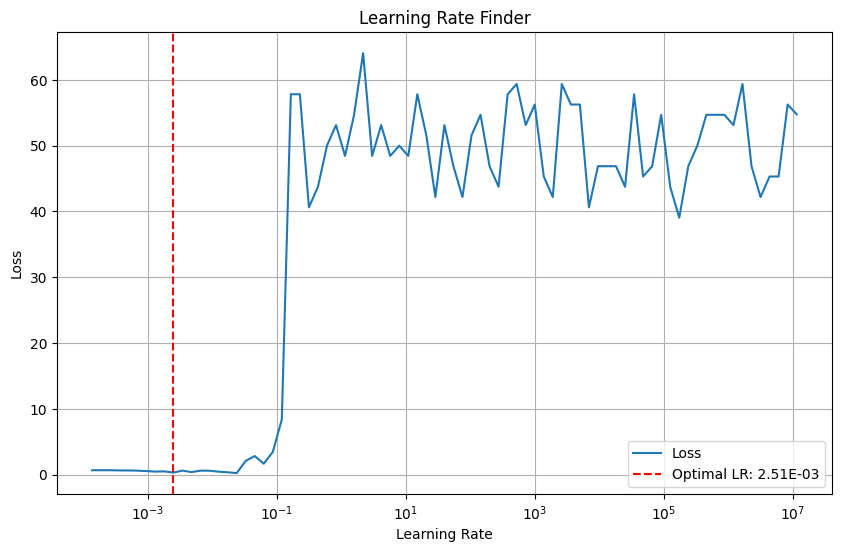

  0%|          | 0/27 [00:09<?, ?it/s]


RuntimeError: all elements of input should be between 0 and 1

COMET ERROR: Due to connectivity issues, there's an error in processing the heartbeat. The experiment's status updates might be inaccurate until the connection issues are resolved.


In [7]:
for model_name, model in selected_models:

    model = model.load_model()
    optimizer_class = dict(all_optimizers)[optimizer_name]

    if optimizer_name in ["SGD", "RMSprop"]:
        optimizer = optimizer_class(model.parameters(), lr=lr, momentum=momentum)
    else:
        optimizer = optimizer_class(model.parameters(), lr=lr)

    trainer = Trainer(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
    )

    trainer.lr_find()

    trainer.train(num_epochs)

    for step in range(trainer.global_step):
        experiment.log_metrics(
            {
                f"{model_name}_{optimizer_name}_train_loss": trainer.history[
                    "train_loss"
                ][step],
                f"{model_name}_{optimizer_name}_train_accuracy": trainer.history[
                    "train_acc"
                ][step],
            },
            step=step + 1,
        )

    for epoch in range(num_epochs):
        print(
            f"Epoch {epoch} - Val Loss: {trainer.history['val_loss'][epoch]}, Val Accuracy: {trainer.history['val_acc'][epoch]}"
        )
        experiment.log_metrics(
            {
                f"{model_name}_{optimizer_name}_val_loss": trainer.history["val_loss"][
                    epoch
                ],
                f"{model_name}_{optimizer_name}_val_accuracy": trainer.history[
                    "val_acc"
                ][epoch],
            },
            epoch=epoch,
        )

    train_table_data = [
        [step, trainer.history["train_loss"][step], trainer.history["train_acc"][step]]
        for step in range(trainer.global_step)
    ]
    val_table_data = [
        [epoch, trainer.history["val_loss"][epoch], trainer.history["val_acc"][epoch]]
        for epoch in range(num_epochs)
    ]

    experiment.log_table(
        filename=f"{model_name}_train_metrics.csv",
        tabular_data=train_table_data,
        headers=["Step", "Train Loss", "Train Accuracy"],
    )

    experiment.log_table(
        filename=f"{model_name}_val_metrics.csv",
        tabular_data=val_table_data,
        headers=["Epoch", "Validation Loss", "Validation Accuracy"],
    )

    predictions, *_ = trainer.test(test_loader)
    metrics.modelPerformance(model_name, optimizer_name, predictions, classes)

    # del model
    # torch.cuda.empty_cache()


In [ ]:

metrics.combine_metrics(selected_models, optimizer_name)

experiment.end()



ResNet18_Adam_train_accuracy,▆▆▅▆▆▆▇▇▇█▇▇▇▇█▁
ResNet18_Adam_train_loss,█▇█▇▇▇▅▅▅▄▆▅▃▂▁▇
ResNet18_Adam_val_accuracy,▁
ResNet18_Adam_val_loss,▁
epoch,▁
global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
ResNet18_Adam_train_accuracy,0.0
ResNet18_Adam_train_loss,0.6936
ResNet18_Adam_val_accuracy,0.72852
ResNet18_Adam_val_loss,0.62251
epoch,0


No wandb run found.


In [ ]:
import segmentation

model_name, model = selected_models[1]
for model_name, model in selected_models:
    segmentation.create_segmentation_plots(
        model, model_name, optimizer_name=optimizer_name
    )